##### Sequence Model

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1}, \ldots, x_1)
$$

##### Markov Models and n-grams

If we can condition only on the $\tau$ previous time steps, i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than the entire sequence history $x_{t-1}, \ldots, x_{1}$, we say that the sequence satisfies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. When $\tau = 1$, we say that the data is characterized by a first-order Markov model, and when $\tau=k$, we say that the data is characterized by a k-order Markov model. 

For when the first-order Markov condition holds ($\tau = 1$) the factorization of our joint probability becomes a product of probabilities of each word given the previous word:

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1})
$$


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

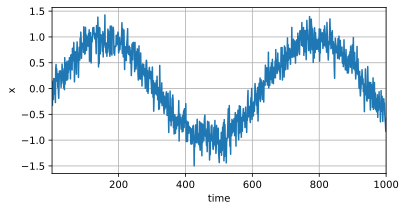

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        # Total 996(T - tau) datas. 600 out of them will be used for training, rest 336 will be used for validating
        # tau: the window length (time lag) used to form features for prediction. The model looks back tau steps to predict next one
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [19]:
# Understanding the dimension parameter in torch.stack()

print("=== torch.stack() with different dimensions ===")

a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6]) 
c = torch.tensor([7, 8, 9])
d = torch.tensor([10, 11, 12])


tensors = [a, b, c, d]
print("torch.stack() input: List/tuple of tensors")
print(f"Input tensors:")
print(f"a = {a}")
print(f"b = {b}")  
print(f"c = {c}")
print(f"d = {d}")

print(f"\n--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---")
stack_0 = torch.stack(tensors, 0)
print(f"Result shape: {stack_0.shape}")
print(f"Result:\n{stack_0}")

print(f"\n--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---")
stack_1 = torch.stack(tensors, 1)  
print(f"Result shape: {stack_1.shape}")
print(f"Result:\n{stack_1}")

print(f"\n=== Why we use dimension 1 for features ===")
print("features[0] = [x[0], x[1], x[2], x[3], x[4], x[5], ..., x[995]]  <- time steps 0-5")
print("features[1] = [x[1], x[2], x[3], x[4], x[5], x[6], ..., x[996]]  <- time steps 1-6") 
print("features[2] = [x[2], x[3], x[4], x[5], x[6], x[7], ..., x[997]]  <- time steps 2-7")
print("features[3] = [x[3], x[4], x[5], x[6], x[7], x[8], ..., x[998]]  <- time steps 3-8")
print("more features")
print("")
print("stack(features, 1) makes each ROW a sliding window:")
print("Row 0: [x[0], x[1], x[2], x[3]]  <- features from time 0,1,2,3")
print("Row 1: [x[1], x[2], x[3], x[4]]  <- features from time 1,2,3,4")
print("Row 2: [x[2], x[3], x[4], x[5]]  <- features from time 2,3,4,5")
print("Row 3: [x[3], x[4], x[5], x[6]]  <- features from time 3,4,5,6")
print("Row 4: [x[4], x[5], x[6], x[7]]  <- features from time 4,5,6,7")
print("Row 5: [x[5], x[6], x[7], x[8]]  <- features from time 5,6,7,8")
print("...")
print("Row 995: [x[995], x[996], x[997], x[998]]  <- features from time 995,996,997,998")
print("This creates (samples × time_steps) shape = (996, 4)")

=== torch.stack() with different dimensions ===
torch.stack() input: List/tuple of tensors
Input tensors:
a = tensor([1, 2, 3])
b = tensor([4, 5, 6])
c = tensor([7, 8, 9])
d = tensor([10, 11, 12])

--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---
Result shape: torch.Size([4, 3])
Result:
tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])

--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---
Result shape: torch.Size([3, 4])
Result:
tensor([[ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [ 3,  6,  9, 12]])

=== Why we use dimension 1 for features ===
features[0] = [x[0], x[1], x[2], x[3], x[4], x[5], ..., x[995]]  <- time steps 0-5
features[1] = [x[1], x[2], x[3], x[4], x[5], x[6], ..., x[996]]  <- time steps 1-6
features[2] = [x[2], x[3], x[4], x[5], x[6], x[7], ..., x[997]]  <- time steps 2-7
features[3] = [x[3], x[4], x[5], x[6], x[7], x[8], ..., x[998]]  <- time steps 3-8
more features

stack(features, 1) makes

In [20]:
# Simple & clear, but very inefficient because of explicit loop

xx = torch.zeros(996, 4)
yy = torch.zeros(996, 1)

for i in range(996):
    xx[i] = data.x[i:i+4]
    yy[i] = data.x[i+4]

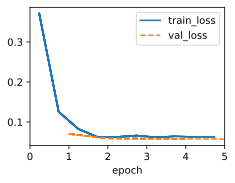

In [21]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    # self.feature.shape: (T - tau, tau, ...)
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    # is below two lines equivalent to above two lines?
    # features = [self.x[i : i+self.tau] for i in range(self.T - self.tau)]
    # self.features = torch.stack(features, 0)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

In [26]:
data.features.shape, data.num_train # 600 for training, 336 for testing

(torch.Size([996, 4]), 600)

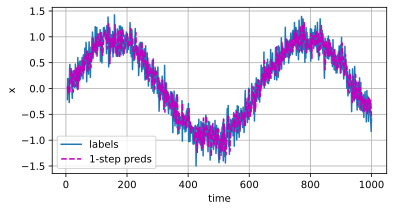

In [27]:
# To evaluate our model, we first check how well it performs at one-step-ahead prediction.

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))

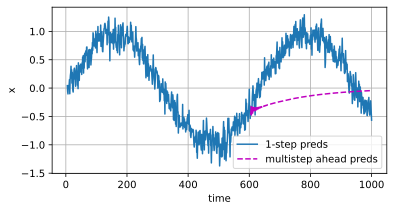

In [ ]:
# multi-step prediction

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
# data.num_train == 600 as default parameter of data = Data() instance
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep ahead preds'], figsize=(6, 3))

# It failed fail spectacularly

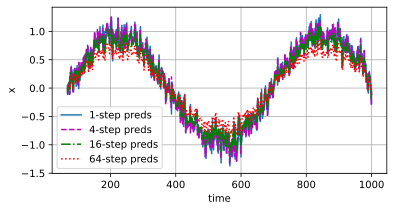

In [30]:
# Let’s take a closer look at the difficulties in k-step-ahead predictions by computing predictions on the entire sequence for k = 1,4,16,64.
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))


======================================Converting Raw Text into Sequence Data===================================

In [31]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [32]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:100]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to '

In [33]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    # For simplicity, we ignore punctuation and capitalization
    # [^...] = Negation; +: One or more consecutive occurrences
    # '[^A-Za-z]+' = 'one or more characters that are NOT letters'
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

In [34]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [37]:
set([1]+[2])

{1, 2}

In [38]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [39]:
vocab = Vocab(tokens)
print("vocab.token_freqs", vocab.token_freqs)
print("vocab.idx_to_token", vocab.idx_to_token)
print("vocab.token_to_idx", vocab.token_to_idx)

indices = vocab[tokens[:10]]

print('indices:', indices)
print('words:', vocab.to_tokens(indices))

vocab.token_freqs [(' ', 32775), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674), ('d', 6337), ('l', 6146), ('m', 4043), ('u', 3805), ('c', 3424), ('f', 3354), ('w', 3225), ('g', 3075), ('y', 2679), ('p', 2427), ('b', 1897), ('v', 1295), ('k', 1087), ('x', 236), ('z', 144), ('j', 97), ('q', 95)]
vocab.idx_to_token [' ', '<unk>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab.token_to_idx {' ': 0, '<unk>': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [40]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [42]:
# word based token:

words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

# ten most frequent words are not all that descriptive: stop words

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

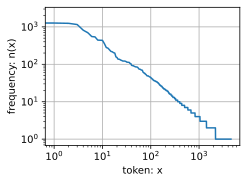

In [43]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

# word frequency decays quickly. The 10-th most frequent word is less than 1/5 as common as the most popular. Word frequency tends to follow a
# power law distribution (specifically the Zipfian) as we go down the ranks.

In [44]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
# Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book — "the time"

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [45]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

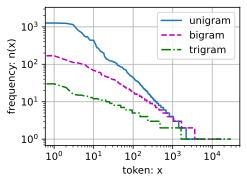

In [46]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

Text is among the most common forms of sequence data encountered in deep learning. 
Common choices for what constitutes a token are characters, words, and word pieces. To preprocess text, we usually 
- split text into tokens; 
- build a vocabulary to map token strings to numerical indices;
- convert text data into token indices for models to manipulate. 

In practice, the frequency of words tends to follow Zipf’s law. This is true not just for individual words (unigrams), but also for n-grams.

============================================Language Models===========================================

In [47]:
import torch
from d2l import torch as d2l

In [48]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [49]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [50]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[20,  0, 16,  7,  0, 17, 19,  6,  4, 10],
        [13,  5,  0, 19,  6, 17, 19,  6, 20,  6]]) 
Y: tensor([[ 0, 16,  7,  0, 17, 19,  6,  4, 10, 20],
        [ 5,  0, 19,  6, 17, 19,  6, 20,  6, 15]])


======================================== Recurrent Neural Networks=========================================

In [63]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

![RNN](./Images/RNN_1.png)

1. **Hidden state**
$
\mathbf{H}_t = \phi_l\left( \mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh} + \mathbf{b}_h \right)
$

2. **Output:**
$
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q
$

In [ ]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        # num_inputs: number of features at each time step (like 27 if using char one-hot embedding, or embedding_dimension if using word embeddings)
        # num_hiddens: number of features at each hidden state
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [ ]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    # Shape of inputs: (num_steps, batch_size, num_inputs)
    # num_steps: how many time steps you feed into the model at once
    # batch_size: how many sequences are processed in parallel
    # num_inputs: number of features at each time step (like 27 if using char one-hot embedding, or embedding_dimension if using word embeddings)
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:
        # Shape of X: (batch_size, num_inputs)
        # state: previous loops' output state
        state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [55]:
num_steps, batch_size, num_inputs, num_hiddens = 100, 2, 16, 32
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [57]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [60]:
X.shape # (100, 2, 16)

# iteration in Python always occurs over the first axis of a Numpy array
for y in X:
    print(y.shape) # (2, 16)
    break

torch.Size([2, 16])


In [ ]:
# RNNScratch: Computes raw hidden states with a manually implemented RNN update
# RNNLMScratch: Adds output prediction + training loop to use RNN for language modeling.

class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        # * is Python unpacking.
        # batch: (X, y), batch[:-1]: (X), *batch[:-1]: X
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Shape of X: (batch_size, num_steps)
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    # outputs: list of (batch_size, vocab_size), length=num_steps
    # return shape: (batch_size, num_steps, vocab_size)
    return torch.stack(outputs, 1)
@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    # shape of X: (batch_size, num_steps)
    # shape of embs: (num_steps, batch_size, vocab_size)
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    # return shape: (batch_size, num_steps, vocab_size)
    return self.output_layer(rnn_outputs)

In [64]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [65]:
# Create RNN with correct input size (vocab_size for one-hot encoding)
rnn = RNNScratch(len(data.vocab), num_hiddens)
model = RNNLMScratch(rnn, len(data.vocab))
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, len(data.vocab)))

Gradient clipping is a crucial technique for training RNNs that prevents the **exploding gradient problem**.

It will:
- Gets all weight matrices and biases that need gradient updates
- Computes L2 norm of ALL gradients combined, This is like measuring the 'magnitude' of the total gradient vector
- Only clip if gradients are too large (exceed threshold)
- Only scale down Proportionally

In [68]:
# gradient clipping

@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    # norm is total squared gradient norm 
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

Why RNNs use gradient clipping — concise summary
- Backprop in RNNs multiplies gradients across many time steps.
- If weights are large, gradients grow exponentially → exploding gradients.
- This makes training blow up — loss becomes NaN, weights shoot to infinity.
- Gradient clipping caps gradient size, preventing instability while keeping direction intact.
- It’s standard practice when training RNNs/LSTMs/GRUs, with typical clip values around 0.5–5.

In [71]:
# During "warm-up" phase (processing the prefix "it has"):
#  - Each character updates the hidden state
#  - Hidden state accumulates information from ALL previous characters
#  - By the end, state contains compressed context of the entire prefix

# During prediction phase:
#  - Uses the accumulated state (containing entire context)
#  - Plus current character → predicts next character
#  - Updates state with new information → predicts next character
#  - And so on...

@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        # get last character from output as input
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [212]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it hasduhijsssssssssssssss'

================================Concise Implementation of Recurrent Neural Networks=============================

In [72]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [73]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [ ]:
class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        # PyTorch's nn.RNN uses time-first format: (time, batch, features)
        # But our loss functions expect batch-first: (batch, time, features)
        #  - swapaxes(0,1) converts time-first → batch-first
        #  - This ensures compatibility with the rest of our code!

        return self.linear(hiddens).swapaxes(0, 1)

In [75]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'it haswymmwymmmmmmmmmmmmmm'

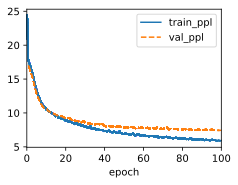

In [217]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

=======================================Backpropagation Through Time==========================s=============

In [ ]:
### TODO read

#### Backpropagation Through Time (BPTT)

##### What is BPTT

- **Backpropagation Through Time (BPTT)** is simply the extension of the standard backpropagation algorithm to recurrent neural networks (RNNs).
- Conceptually, we **“unroll”** the RNN across time steps: treat a sequence of length *T* as a deep feedforward network of depth *T*, where the same parameters are reused (shared) at each time step.
- Then we apply the chain rule (backprop) through this unrolled network, accumulating gradients for the shared parameters across all time steps.

##### Challenges: Vanishing & Exploding Gradients

- Because the same parameter matrices are multiplied repeatedly through many time steps, gradients can **vanish** (shrink toward 0) or **explode** (grow exponentially) depending on the eigenvalues of these matrices.
- For very long sequences (hundreds or thousands of time steps), this becomes a major problem: either the model fails to learn long-term dependencies (vanishing), or training becomes unstable (exploding).

##### Truncated BPTT — A Practical Fix

- Doing full BPTT over very long sequences is often computationally infeasible (memory and time) and numerically unstable.
- Instead practitioners often use **truncated BPTT** (TBPTT): split sequences into smaller subsequences (windows), run BPTT over each window, and carry forward the hidden state across windows. This reduces memory load and stabilizes gradients.
- Two common truncation strategies:
  - **Regular truncation**: partition the sequence into fixed-length windows.  
  - **Randomized truncation**: partition at random intervals to reduce correlation between subsequences (regularization effect).

##### How BPTT Works (in Detail)

1. **Forward pass:** feed the sequence step by step, updating hidden states.  
2. **Unroll** the entire (or truncated) RNN over time — treat as a deep feedforward graph.  
3. **Loss computation:** compute loss across all time steps (or subsequence).  
4. **Backward pass:** apply chain rule through time — compute gradients for each parameter by summing contributions from every time-step instance. 
5. **Parameter update:** update shared weights using the accumulated gradients.

For efficiency, intermediate values (e.g. hidden states at each time step) are cached so they can be reused during the backward pass.
##### Why BPTT Matters

- BPTT allows RNNs to learn temporal dependencies: it ensures earlier inputs influence gradients computed based on later outputs. Without BPTT, RNNs couldn’t learn sequence-level patterns.  
- Despite its drawbacks (gradient instability, high memory/computation cost), BPTT remains the fundamental training method for RNNs, including more advanced variants like LSTMs or GRUs.

##### Summary (Key Points)

- BPTT = unroll RNN in time + apply backprop as in feedforward nets.
- Gradient stability is a core issue — vanishing or exploding gradients degrade training, especially for long sequences.
- Use **truncated BPTT** to manage computation and stability; often combined with **gradient clipping**. (The latter discussed elsewhere in d2l.) 
- BPTT underlies training of all RNN-based models regardless of architecture (vanilla RNN, LSTM, GRU).